# 4. 훈련

- **머신러닝의 내부가 어떻게 작동하는지 파악할 수 있다면 디버깅이나 에러를 효율적으로 분석하는데 도움이 된다.**

- **기초적인 선형대수에 대해 알고 있어야 이해에 도움이 된다.**

## 4.1 선형회귀

- 일반적으로 선형 모델은 입력 특성의 가중치 합과 편향을 더해 예측을 생성. **그러므로 선형 회귀란 이 가중치들($\theta$)를 적절하게 조절하여 잘 맞는 예측값을 생성하는 것이다.**

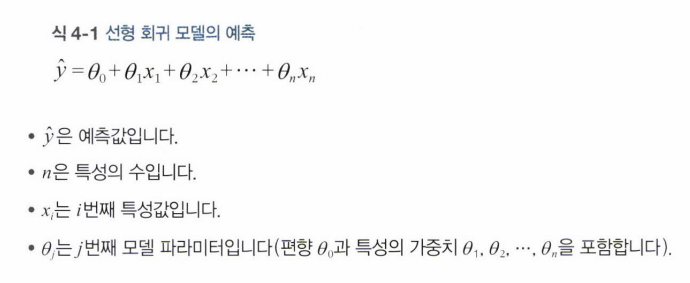

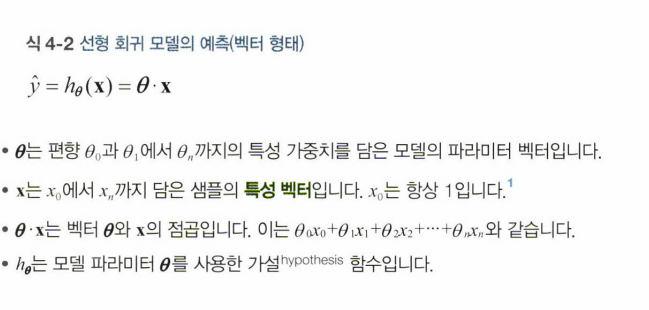


- 보통은 벡터를 하나의 열을 가진 2D 배열인 **열 벡터**로 나타낸다. $\theta$와 $X$가 열벡터라면 예측은 $\theta^T$ 와 $X$의 행렬 곱이다.


-  우리가 회귀에서 가장 많이 사용하는 성능 측정 지표는 RMSE이므로 이러한 Cost function을 최소화하는 $\theta$를 찾아야 한다.

## 4.1.1 정규방정식

- 앞서 말했던 Cost function을 최소화하는 파라미터를 구하기 위해서 수학적인 공식을 사용할 수 있다. 이를 **정규방정식**이라고 한다. 다시 말하자면 다항 방정식을 행렬로 나타내고, 역행렬을 통해 최적의 값을 찾는 방법이라고  할 수 있다.

    보통 우리는 어떠한 함수의 최솟값을 찾으려고 할 땐 **미분**을 취하는데 다항식이므로 각 변수에 대한 **편미분을 취함으로써** 최소값을 구할 수 있다. 자세한 식은 추후에 업로드...


- 정규방정식의 계산 복잡도는 $n^{2.4} 부터 n^3$정도가 되며, SVD 방법은 $n^2$이다. 그러므로 특성 수 (고차원)일수록 걸리는 시간이 매우 늘어나게 된다. 그러나 훈련 세트의 샘플 수에 대해서는 선형적으로 증가해 메모리 공간이 허락된다면 훈련 세트도 효율적으로 처리가 가능하다.
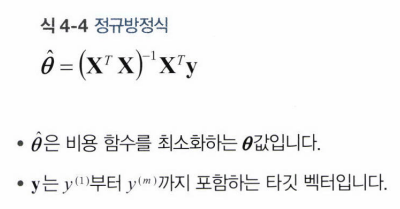

In [3]:
import numpy as np
import pandas as pd

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

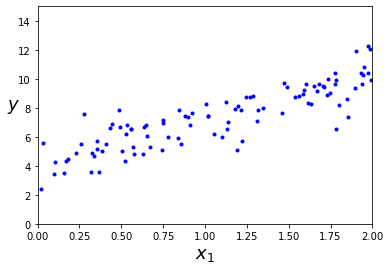

In [5]:
import matplotlib.pyplot as plt
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [6]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가.

# numpy 선형대수 모듈에 있는 inv()로 역행렬 계산 , dot()로 내적.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [7]:
theta_best

array([[4.07085698],
       [3.06546256]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.07085698],
       [10.20178209]])

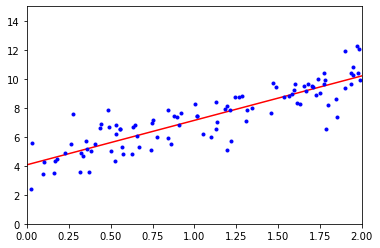

In [9]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [10]:
# 사이킷런의 linear regression으로 해보기
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# intercept가 편향, coef가 변수(세타)로 직접 확인할 수 있음.
lin_reg.intercept_, lin_reg.coef_ 

(array([4.07085698]), array([[3.06546256]]))

In [11]:
# LinearRegerssion 클래스는 scipy.linalg.lstsq() 함수를 기반으로 한다.
lin_reg.predict(X_new)

array([[ 4.07085698],
       [10.20178209]])

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.07085698],
       [3.06546256]])

- 위의 함수는 $\hat\theta = X^+ y$ 을 계산하는데 여기서 $X^+$는 **유사역행렬(pseudoinverse)**를 뜻한다. 이를 사용하는 이유는 행렬 $X^T X$의 역행렬이 없는 경우 유사 역행렬은 항상 구할 수 있기 때문이고, 극단적인 경우에도 처리가 가능하다.<p>

    - 유사 역행렬을 SVD(특이값 분해)를 통해 구해진다.

In [13]:
# np.linalg.pinv()로 유사 역행렬을 직접 구할 수 있다.
np.linalg.pinv(X_b).dot(y)

array([[4.07085698],
       [3.06546256]])

## 4.2 경사하강법

- 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘으로, 비용함수를 최소화하기 위해 반복해서 기울기를 구하여 최소값 방향으로 파라미터를 조정해가는 것이다. 처음에는 $\theta$를 임의의 값으로 시작하는 random initialization을 진행한다.


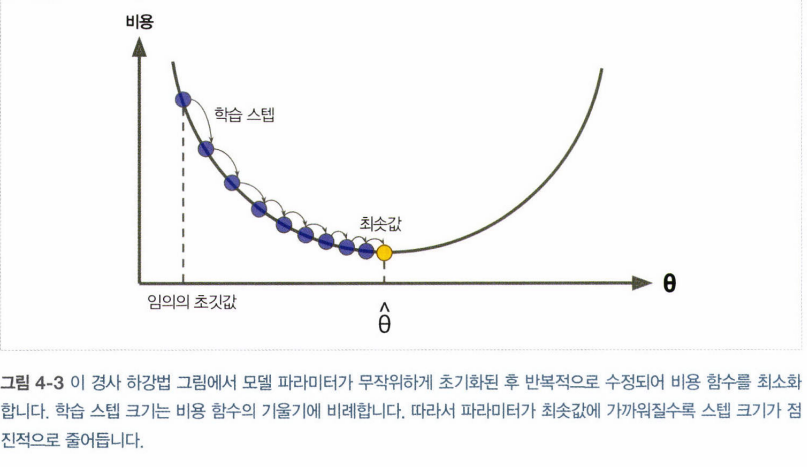


- 경사하강법은 학습률을 통해 한번에 얼마나 많은 step 즉, 보폭을 움직일지 결정할 수 있다. 이는 너무 커서도 작아서도 안되며 적절한 값을 찾아야 한다.<p>

    - lr이 너무 낮으면 : 최소값이 되는 부분을 넘어가지 않고 천천히 탐색, 그러나 시간이 너무 오래걸리고 local minimum에 수렴될 수 있음.<p>
    
    - lr이 너무 크면 : 최소값이 되는 부분까지 빠르게 탐색가능하고, local minimum을 뛰어넘을 수 있지만, 수렴되지 못하고 발산될 가능성이 높다. 
    
    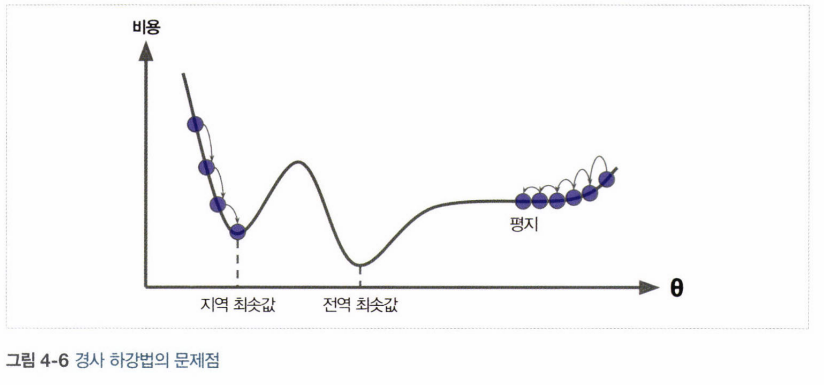
        
     
- 위 그림을 보면 local minimum이 생기는 오목 함수(non-convex function)로 이러한 지역  최소값이 생긴다면 global minimum을 찾아가는 것이 매우 어렵지만, 선형회귀를 위한 MSE cost function은 convex function으로 무조건 **하나의 전역 최소값이 있어** 경사하강법이 최소값을 찾는데에 훨씬 쉽다. 그러므로 **convex function**에서의 경사 하강법은 강력하다. 
        
        
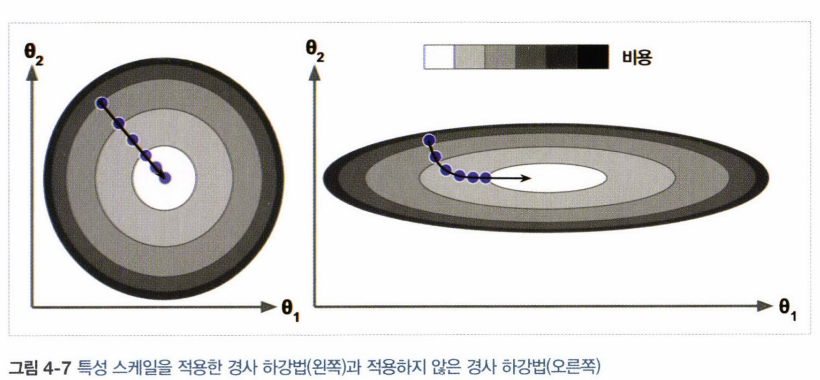
        

- cost function은 사실 위의 그림과 같은데 만약 변수들간의 scale이 다르다면 오른쪽 그림처럼 길쭉한 모양이 될 수 있다. 이러한 모양은 최소값 수렴에 더 오래 걸리는 결과를 초래하므로 경사하강법을 사용할 때는 **Feature scaling이 필수적이다.**
        

- 이렇게 많은 파라미터들이 있는 모델의 **파라미터 공간**에서 모델의 파라미터가 많을 수록 공간의 차원은 커지고, 최적해를 찾는것은 더 어려울 것이다.